<a href="https://colab.research.google.com/github/seongyeon1/twitterNLP/blob/main/sentiments_stopwords__modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')


# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Tensorflow
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.8.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


# Upload Datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_IN_PATH = '/content/drive/MyDrive/ColabNotebooks/datasets/sentiments/'

In [ ]:
print("파일 크기 : ")
for file in os.listdir(DATA_IN_PATH):
    if 'csv' in file :
        print(file.ljust(30) + str(round(os.path.getsize(DATA_IN_PATH + file) / 1000000, 2)) + 'MB')

파일 크기 : 
train.csv                     1.1MB
test.csv                      0.26MB
sample_submission.csv         0.02MB
submission.csv                0.01MB
submission_nostopwords.csv    0.01MB


In [ ]:
train_data = pd.read_csv(DATA_IN_PATH + 'train.csv')
test_data = pd.read_csv(DATA_IN_PATH + 'test.csv')
train_data.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [ ]:
df = pd.concat([train_data, test_data])

In [ ]:
df

,id,label,tweet
0,1,0.0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0.0,Finally a transparant silicon case ^^ Thanks t...
2,3,0.0,We love this! Would you go? #talk #makememorie...
3,4,0.0,I'm wired I know I'm George I was made that wa...
4,5,1.0,What amazing service! Apple won't even talk to...
...,...,...,...
1948,9869,NaN,"#SamsungGalaxyNote7 Explodes, Burns 6-Year-Old..."
1949,9870,NaN,Now Available - Hoodie. Check it out here - ht...
1950,9871,NaN,There goes a crack right across the screen. If...
1951,9872,NaN,@codeofinterest as i said #Adobe big time we m...


# <strong>데이터 탐색(EDA)</strong>

In [ ]:
test_data.head()

,id,tweet
0,7921,I hate the new #iphone upgrade. Won't let me d...
1,7922,currently shitting my fucking pants. #apple #i...
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t..."
3,7924,My ipod is officially dead. I lost all my pict...
4,7925,Been fighting iTunes all night! I only want th...


In [ ]:
print('전체 학습데이터의 개수: {}'.format(len(train_data)))
print('전체 테스트 데이터의 개수: {}'.format(len(test_data)))

전체 학습데이터의 개수: 7920
전체 테스트 데이터의 개수: 1953


Counter({0: 5894, 1: 2026})


Text(0.5, 1.0, 'Dataset labels distribuition')

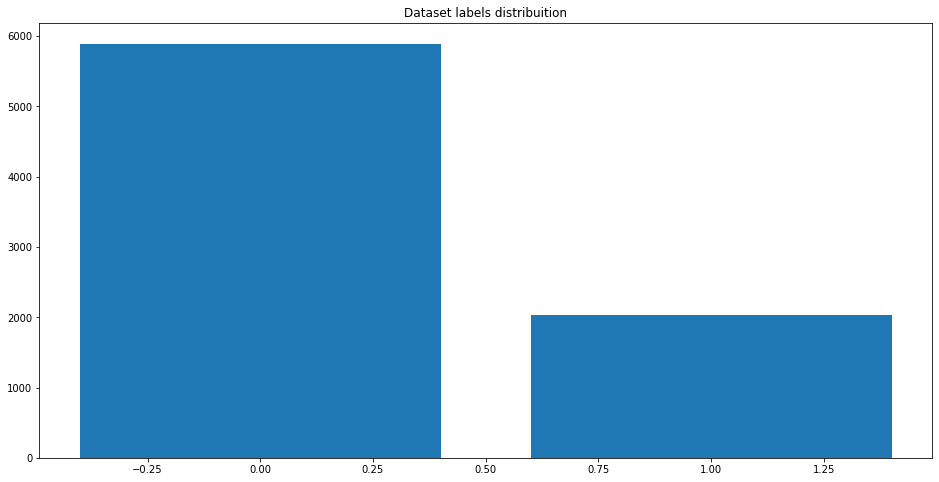

In [ ]:
from collections import Counter

target_cnt = Counter(train_data.label)
print(target_cnt)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

- #(hashtag)나 url 들을 전처리 해야할 것 같다
- hashtag 전처리 방법 생각하기
- url 전처리 방법 생각하기
- stopword(불용어) 처리

In [ ]:
train_length = train_data['tweet'].astype(str).apply(len)
train_length.head()

0    128
1    131
2    123
3    112
4    124
Name: tweet, dtype: int64

# Word_tokenize

In [ ]:
text = train_data.loc[0,'tweet']
print(word_tokenize(text))

['#', 'fingerprint', '#', 'Pregnancy', 'Test', 'https', ':', '//goo.gl/h1MfQV', '#', 'android', '#', 'apps', '#', 'beautiful', '#', 'cute', '#', 'health', '#', 'igers', '#', 'iphoneonly', '#', 'iphonesia', '#', 'iphone']


In [ ]:
# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [ ]:
# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

In [ ]:
# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = 0
NEGATIVE = 1
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [ ]:
[re.search(r'[a-z]+\'t', str(stop_word)) for stop_word in stop_words]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 <re.Match object; span=(0, 5), match="don't">,
 None,
 None,
 None,
 None,


In [ ]:
def preprocess(text, stem=False):
    # Remove link, user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        #if token not in stop_words:
        if stem:
            tokens.append(stemmer.stem(token))
        else:
            tokens.append(token)
    return " ".join(tokens)

In [ ]:
%%time
df.tweet = df.tweet.apply(lambda x: preprocess(x))

CPU times: user 114 ms, sys: 0 ns, total: 114 ms
Wall time: 116 ms


In [ ]:
df

,id,label,tweet
0,1,0.0,fingerprint pregnancy test android apps beauti...
1,2,0.0,finally a transparant silicon case thanks to m...
2,3,0.0,we love this would you go talk makememories un...
3,4,0.0,i m wired i know i m george i was made that wa...
4,5,1.0,what amazing service apple won t even talk to ...
...,...,...,...
1948,9869,NaN,samsunggalaxynote7 explodes burns 6 year old t...
1949,9870,NaN,now available hoodie check it out here iphone ...
1950,9871,NaN,there goes a crack right across the screen if ...
1951,9872,NaN,as i said adobe big time we may well as includ...


In [ ]:
df_train = df[:7920]

In [ ]:
df_train.tail()

,id,label,tweet
7915,7916,0.0,live out loud lol liveoutloud selfie smile son...
7916,7917,0.0,we would like to wish you an amazing day make ...
7917,7918,0.0,helping my lovely 90 year old neighbor with he...
7918,7919,0.0,finally got my smart pocket wifi stay connecte...
7919,7920,0.0,apple barcelona apple store bcn barcelona trav...


In [ ]:
df_test = df[7920:]

In [ ]:
df_test.head()

,id,label,tweet
0,7921,NaN,i hate the new iphone upgrade won t let me dow...
1,7922,NaN,currently shitting my fucking pants apple imac...
2,7923,NaN,i d like to puts some cd roms on my ipad is th...
3,7924,NaN,my ipod is officially dead i lost all my pictu...
4,7925,NaN,been fighting itunes all night i only want the...


In [ ]:
train_good = df_train[df_train.label==0].sample(n=2026,replace=False)
train_bad = df_train[df_train.label==1]
df_train = pd.concat([train_good, train_bad])

In [ ]:
%%time
documents = [_text.split() for _text in df_train.tweet]

CPU times: user 7.71 ms, sys: 1.98 ms, total: 9.68 ms
Wall time: 10.7 ms


In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 883


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 3.85 s, sys: 57.7 ms, total: 3.91 s
Wall time: 2.3 s


(1163514, 2204832)

In [ ]:
w2v_model.wv.most_similar("apple")

[('os', 0.6678919792175293),
 ('applesucks', 0.6502076387405396),
 ('fuckyou', 0.6392196416854858),
 ('suck', 0.6363205909729004),
 ('crappy', 0.6260895729064941),
 ('pro', 0.5785127282142639),
 ('ipads', 0.5780731439590454),
 ('college', 0.5616276264190674),
 ('though', 0.5568529367446899),
 ('maps', 0.5409600138664246)]

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.tweet)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 10768
CPU times: user 126 ms, sys: 92.7 ms, total: 218 ms
Wall time: 123 ms


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.tweet), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.tweet), maxlen=SEQUENCE_LENGTH)

CPU times: user 111 ms, sys: 905 µs, total: 112 ms
Wall time: 113 ms


In [ ]:
labels = df_train.label.unique().tolist()
labels

[0.0, 1.0]

In [ ]:
df_test.label = df_test.label.fillna(0)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.label.tolist())

y_train = encoder.transform(df_train.label.tolist())
y_test = encoder.transform(df_test.label.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (4052, 1)
y_test (1953, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (4052, 300)
y_train (4052, 1)

x_test (1953, 300)
y_test (1953, 1)


In [ ]:
y_train[:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

# Embedding layer

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(10768, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

# Build Model

In [ ]:
model = Sequential()
model.add(tf.keras.layers.Embedding(1000, 300, input_length=300))
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          300000    
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 460,501
Trainable params: 460,501
Non-trainable params: 0
_________________________________________________________________


# Compile model

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

# Callbacks

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

# Train

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
4/4 [==============================] - 13s 1s/step - loss: 0.6852 - accuracy: 0.6034 - val_loss: 0.7246 - val_accuracy: 0.1182 - lr: 0.0010
Epoch 2/8
4/4 [==============================] - 5s 1s/step - loss: 0.6491 - accuracy: 0.5933 - val_loss: 0.8722 - val_accuracy: 0.0443 - lr: 0.0010
Epoch 3/8
4/4 [==============================] - 5s 1s/step - loss: 0.5888 - accuracy: 0.6574 - val_loss: 0.6692 - val_accuracy: 0.6330 - lr: 0.0010
Epoch 4/8
4/4 [==============================] - 5s 1s/step - loss: 0.4865 - accuracy: 0.8064 - val_loss: 0.4666 - val_accuracy: 0.8645 - lr: 0.0010
Epoch 5/8
4/4 [==============================] - 5s 1s/step - loss: 0.3922 - accuracy: 0.8472 - val_loss: 0.2626 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 6/8
4/4 [==============================] - 5s 1s/step - loss: 0.3546 - accuracy: 0.8631 - val_loss: 0.3398 - val_accuracy: 0.9015 - lr: 0.0010
Epoch 7/8
4/4 [==============================] - 5s 1s/step - loss: 0.3046 - accuracy: 0.8774 - val_loss:

# Evaluate

In [ ]:
%%time
score = model.evaluate(x_train, y_train, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

4/4 [==============================] - 1s 190ms/step - loss: 0.2726 - accuracy: 0.8993

ACCURACY: 0.899308979511261
LOSS: 0.27262210845947266
CPU times: user 688 ms, sys: 47.3 ms, total: 735 ms
Wall time: 913 ms


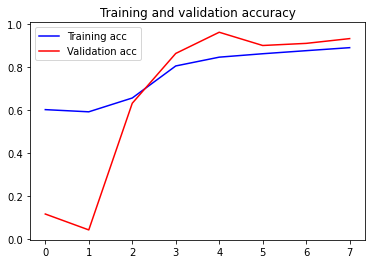

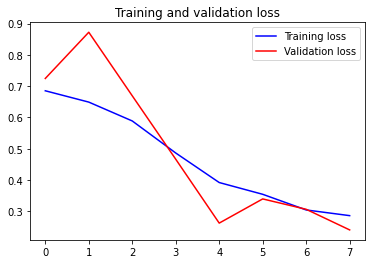

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Predict

In [ ]:
def decode_sentiment(score):
  return POSITIVE if score < 0.5 else NEGATIVE

In [ ]:
def predict(text):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [ ]:
predict("I don't love iphone")

{'elapsed_time': 0.4004099369049072, 'label': 0, 'score': 0.03136955201625824}

In [ ]:
predict("I hate apple")

{'elapsed_time': 0.11260986328125, 'label': 0, 'score': 0.3733757734298706}

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.label)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score) for score in scores]

1/1 [==============================] - 0s 370ms/step
CPU times: user 395 ms, sys: 21.2 ms, total: 417 ms
Wall time: 561 ms


In [ ]:
submission = pd.read_csv((DATA_IN_PATH + 'sample_submission.csv'))

In [ ]:
submission.label = y_pred_1d

In [ ]:
submission.head()

,id,label
0,7921,1
1,7922,0
2,7923,1
3,7924,1
4,7925,1


In [ ]:
submission.to_csv((DATA_IN_PATH + 'submission_nostopwords.csv'), index=False)

In [ ]:
y_test_1d

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

0.6246799795186891

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

In [ ]:
df_test

,id,label,tweet
0,7921,0.0,i hate the new iphone upgrade won t let me dow...
1,7922,0.0,currently shitting my fucking pants apple imac...
2,7923,0.0,i d like to puts some cd roms on my ipad is th...
3,7924,0.0,my ipod is officially dead i lost all my pictu...
4,7925,0.0,been fighting itunes all night i only want the...
...,...,...,...
1948,9869,0.0,samsunggalaxynote7 explodes burns 6 year old t...
1949,9870,0.0,now available hoodie check it out here iphone ...
1950,9871,0.0,there goes a crack right across the screen if ...
1951,9872,0.0,as i said adobe big time we may well as includ...


In [ ]:
scores

array([[0.89347595],
       [0.4398267 ],
       [0.92951244],
       ...,
       [0.89883804],
       [0.8695519 ],
       [0.03354437]], dtype=float32)